# Shap Experiments: does Shap importance make sense?

In this notebook, we try to validate Shap importance feedback on a classification model. Two Shap-based data manipulations are used to assess the impact on the model performance:
- In the training data, change feature value for M most Shap-important features for all false predictions, run the model again and see if they are predicted correctly;
- In the test data, change feature value for M most Shap-important features for all false predictions, run prediction again (without re-training the model) and see if they are predicted correctly.

### Data management and classification

A small data from FIFA 2018 World Cup is used along with a Random Forest classifier. Training data is made of 102 rows, test data of 26.

In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# load JS visualization code to notebook
shap.initjs()

N = 5 # Number of trees
data = pd.read_csv('D:\datalake\public\FIFA 2018 Statistics.csv')
# y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
# X = data[feature_names]
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
train, test = train_test_split(data, test_size=0.2, random_state=1)
train_X = train[feature_names]
train_y = (train['Man of the Match'] == "Yes")
test_X = test[feature_names]
test_y = (test['Man of the Match'] == "Yes")
my_model = RandomForestClassifier(random_state=0, n_estimators=N).fit(train_X, train_y)

In [2]:
row_to_show = 0
data_for_prediction = test_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

my_model.predict_proba(data_for_prediction_array)

array([[0.8, 0.2]])

In [3]:
from sklearn.metrics import classification_report

print("Classification report for train data")
print
train_pred_y = my_model.predict(train_X)
print(classification_report(train_y, train_pred_y))

print("Classification report for test data")
print
test_pred_y = my_model.predict(test_X)
print(classification_report(test_y, test_pred_y))

Classification report for train data
              precision    recall  f1-score   support

       False       0.94      0.94      0.94        51
        True       0.94      0.94      0.94        51

    accuracy                           0.94       102
   macro avg       0.94      0.94      0.94       102
weighted avg       0.94      0.94      0.94       102

Classification report for test data
              precision    recall  f1-score   support

       False       0.75      0.69      0.72        13
        True       0.71      0.77      0.74        13

    accuracy                           0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



In [4]:
feature_names

['Goal Scored',
 'Ball Possession %',
 'Attempts',
 'On-Target',
 'Off-Target',
 'Blocked',
 'Corners',
 'Offsides',
 'Free Kicks',
 'Saves',
 'Pass Accuracy %',
 'Passes',
 'Distance Covered (Kms)',
 'Fouls Committed',
 'Yellow Card',
 'Yellow & Red',
 'Red',
 'Goals in PSO']

In [5]:
train['label'] = train.apply(lambda row: row['Man of the Match'] == "Yes", axis=1)
train.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Date,Team,Opponent,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,...,Yellow & Red,Red,Man of the Match,1st Goal,Round,PSO,Goals in PSO,Own goals,Own goal Time,label
80,27-06-2018,Korea Republic,Germany,2,30,11,5,5,1,3,...,0,0,Yes,90.0,Group Stage,No,0,NaN,NaN,True
44,21-06-2018,Argentina,Croatia,0,58,10,3,3,4,5,...,0,0,No,NaN,Group Stage,No,0,NaN,NaN,False
99,30-06-2018,Portugal,Uruguay,1,61,20,5,1,8,10,...,0,0,No,55.0,Round of 16,No,0,NaN,NaN,False
54,23-06-2018,Korea Republic,Mexico,1,41,17,6,2,9,7,...,0,0,No,90.0,Group Stage,No,0,NaN,NaN,False
83,27-06-2018,Sweden,Mexico,3,35,13,5,7,1,3,...,0,0,Yes,50.0,Group Stage,No,0,NaN,NaN,True


In [6]:
x_ratios = pd.DataFrame()
df = train
target = 'label'
df=df[df[target].isnull()==False]
vc=df[target].value_counts()
g=pd.DataFrame(df.groupby('Goals in PSO')[target].value_counts())

In [7]:
vc

True     51
False    51
Name: label, dtype: int64

In [8]:
g[target]

Goals in PSO  label
0             False    50
              True     48
3             False     1
4             True      3
Name: label, dtype: int64

In [9]:
g

label
Goals in PSO label       
0            False     50
             True      48
3            False      1
4            True       3

In [10]:
g=g.rename({target:"count"},axis=1).reset_index()

In [11]:
g

,Goals in PSO,label,count
0,0,False,50
1,0,True,48
2,3,False,1
3,4,True,3


In [12]:
def label_race (row, cols):
    feature_value_target_count = row['count']
    total_target_count = float(vc[row[target]])
    if cols == 'Goals in PSO':
        print('feature_value_target_count ' + str(feature_value_target_count))
        print('total_target_count ' + str(total_target_count))
    return feature_value_target_count/total_target_count

In [13]:
p_a=df['Goals in PSO'].value_counts(normalize=True)
p_a.head()

0    0.960784
4    0.029412
3    0.009804
Name: Goals in PSO, dtype: float64

In [14]:
def label_xratio (row, cols):
    propotion_feature_value_label = row['p_a_c']
    propotion_feature_value = p_a[row[cols]]
    if cols == 'Goals in PSO':
        print('propotion_feature_value_label ' + str(propotion_feature_value_label))
        print('propotion_feature_value ' + str(propotion_feature_value))
    return propotion_feature_value_label/propotion_feature_value

In [15]:
selected_columns = feature_names
       
       
if len(selected_columns)>0:
    x_ratios = pd.DataFrame()
    df = train
    target = 'label'
    df=df[df[target].isnull()==False]
    vc=df[target].value_counts()
    
            
    for cols in selected_columns:
        ratios = pd.DataFrame()
        p_a=df[cols].value_counts(normalize=True)
        g=pd.DataFrame(df.groupby(cols)[target].value_counts())
        g=g.rename({target:"count"},axis=1).reset_index()
        g['p_a_c']=g.apply(lambda row: label_race(row, cols), axis=1)
        g['x_ratio']=g.apply(lambda row:label_xratio(row, cols),axis=1)
        g.columns = ['feature','target','value_count','p_a_c','x_ratio']
        g['feature_name'] = cols
        g.sort_values('x_ratio',ascending=False,inplace=True)
        targets = list(train[target].unique())
        ncols = len(targets)
        x_ratios = pd.concat((g,x_ratios))


feature_value_target_count 50
total_target_count 51.0
feature_value_target_count 48
total_target_count 51.0
feature_value_target_count 1
total_target_count 51.0
feature_value_target_count 3
total_target_count 51.0
propotion_feature_value_label 0.9803921568627451
propotion_feature_value 0.9607843137254902
propotion_feature_value_label 0.9411764705882353
propotion_feature_value 0.9607843137254902
propotion_feature_value_label 0.0196078431372549
propotion_feature_value 0.00980392156862745
propotion_feature_value_label 0.058823529411764705
propotion_feature_value 0.029411764705882353


In [16]:
x_ratios[x_ratios['feature_name'] == 'Goals in PSO']

,feature,target,value_count,p_a_c,x_ratio,feature_name
2,3,False,1,0.019608,2.000000,Goals in PSO
3,4,True,3,0.058824,2.000000,Goals in PSO
0,0,False,50,0.980392,1.020408,Goals in PSO
1,0,True,48,0.941176,0.979592,Goals in PSO


In [17]:
x_ratios[x_ratios['feature_name'] == 'Goal Scored']

,feature,target,value_count,p_a_c,x_ratio,feature_name
8,4,True,2,0.039216,2.000000,Goal Scored
9,5,True,2,0.039216,2.000000,Goal Scored
10,6,True,1,0.019608,2.000000,Goal Scored
0,0,False,25,0.490196,1.851852,Goal Scored
6,3,True,7,0.137255,1.555556,Goal Scored
4,2,True,17,0.333333,1.416667,Goal Scored
2,1,True,20,0.392157,1.081081,Goal Scored
3,1,False,17,0.333333,0.918919,Goal Scored
5,2,False,7,0.137255,0.583333,Goal Scored
7,3,False,2,0.039216,0.444444,Goal Scored


### Shap values calculation using a TreeExplainer

In [18]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(model=my_model)

# Calculate Shap values
shap_values = explainer.shap_values(train_X)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [19]:
shap_values_df = pd.DataFrame(shap_values[1], columns=train_X.columns)

In [20]:
train_X.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
80,2,30,11,5,5,1,3,0,8,7,74,237,118,16,4,0,0,0
44,0,58,10,3,3,4,5,3,26,2,81,505,101,15,3,0,0,0
99,1,61,20,5,1,8,10,1,13,1,84,583,107,13,1,0,0,0
54,1,41,17,6,2,9,7,0,7,3,82,346,99,24,4,0,0,0
83,3,35,13,5,7,1,3,0,16,3,67,212,102,11,2,0,0,0


In [21]:
shap_values_df.head()

,Goal Scored,Ball Possession %,Attempts,On-Target,Off-Target,Blocked,Corners,Offsides,Free Kicks,Saves,Pass Accuracy %,Passes,Distance Covered (Kms),Fouls Committed,Yellow Card,Yellow & Red,Red,Goals in PSO
0,0.121860,-0.007150,0.004469,0.089739,0.050008,0.049438,0.008517,-0.023629,0.011875,0.068735,0.043482,-0.019864,0.050055,0.064949,0.011043,0.0,0.0,0.0
1,-0.336647,0.010671,-0.019204,-0.043862,0.019145,0.009688,-0.004691,0.011624,-0.023672,-0.014251,-0.004355,-0.059778,-0.003186,-0.021060,0.003106,0.0,0.0,0.0
2,-0.025643,0.007147,0.027745,0.039917,-0.353077,-0.148852,-0.000669,-0.001077,-0.008424,-0.000512,-0.014019,-0.003118,0.014439,-0.006082,-0.004245,0.0,0.0,0.0
3,-0.021744,-0.018589,0.026923,-0.006625,-0.194960,-0.132112,-0.006320,-0.023314,-0.047707,-0.013464,-0.017515,-0.029912,-0.002313,0.008197,0.002985,0.0,0.0,0.0
4,0.135133,-0.001551,0.033466,0.094934,0.029235,-0.011356,0.011475,-0.010089,0.063234,-0.002250,-0.001033,-0.034021,-0.000087,0.029392,-0.012951,0.0,0.0,0.0


In [22]:
importance = shap_values_df.abs().mean(axis=0)
importance.sort_values(axis=0, ascending=False, inplace=True)
importance

Goal Scored               0.137703
On-Target                 0.070047
Off-Target                0.058888
Attempts                  0.052324
Passes                    0.050197
Blocked                   0.038952
Pass Accuracy %           0.030991
Fouls Committed           0.026929
Free Kicks                0.023582
Saves                     0.019707
Ball Possession %         0.018442
Distance Covered (Kms)    0.017296
Corners                   0.015105
Offsides                  0.013010
Yellow Card               0.007532
Red                       0.000000
Yellow & Red              0.000000
Goals in PSO              0.000000
dtype: float64

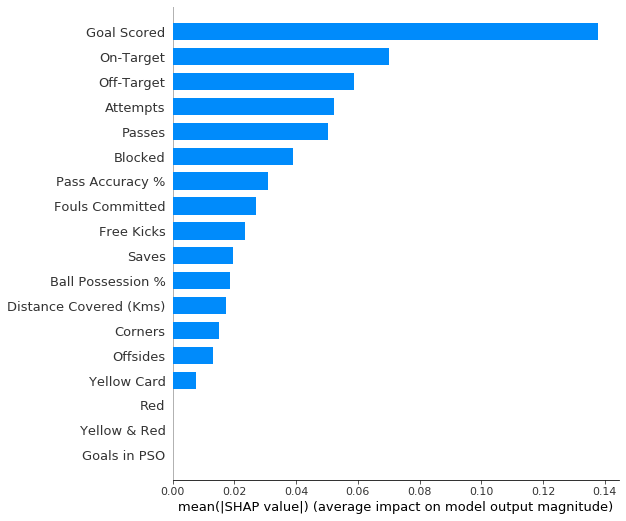

In [23]:
shap.summary_plot(shap_values[1], train_X, plot_type='bar')

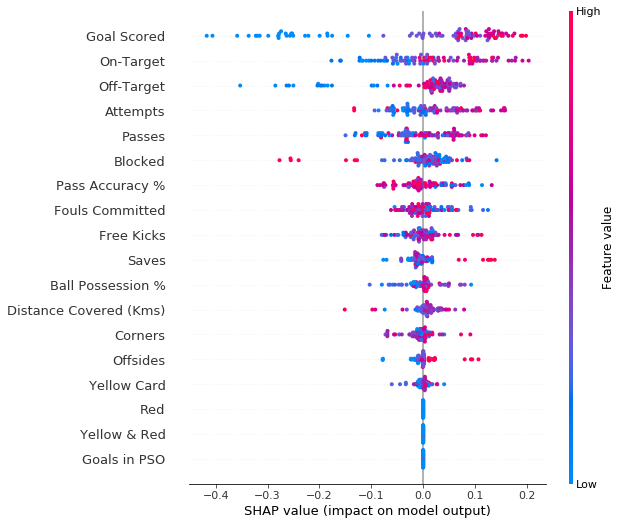

In [24]:
shap.summary_plot(shap_values[1], train_X)

### False predictions

In [25]:
train_false_pred = np.where(np.logical_xor(train_pred_y, train_y))
print("false predictions in train data ")
print(train_false_pred)
test_false_pred = np.where(np.logical_xor(test_pred_y, test_y))
print("false predictions in test data ")
print(test_false_pred)

false predictions in train data 
(array([ 15,  23,  26,  47,  77, 100], dtype=int64),)
false predictions in test data 
(array([ 5,  8, 11, 13, 22, 24, 25], dtype=int64),)


### Feature modification

The M most Shap-important features values for false predictions (M=2) are modified as follow:
- False negative case: we replace with the most important value of the feature;
- False positive case: we replace with the less important value of the feature.

In [26]:
train_X_modified = train_X.copy()
test_X_modified  = test_X.copy()

In [27]:
M=2
for j in range(M):
    df = pd.DataFrame()
    col = importance.index[j]
    df[col] = train_X[col]
    df['shap'] = shap_values_df[col]
    df = df.groupby(by=col).agg('mean').sort_values(by='shap', ascending=False).reset_index()
    for i in train_false_pred[0]:
        if train_y.iloc[i]:
            train_X_modified.iloc[i][col] = df.iloc[0][col]
        else:
            train_X_modified.iloc[i][col] = df.iloc[-1][col]
    for i in test_false_pred[0]:
        if test_y.iloc[i]:
            test_X_modified.iloc[i][col] = df.iloc[0][col]
        else:
            test_X_modified.iloc[i][col] = df.iloc[-1][col]

Repeating predictions shows new modified test data make it possible to predict correctly 5 out of the 7 false predictions.

In [28]:
test_pred_y = my_model.predict(test_X_modified)
test_false_pred = np.where(np.logical_xor(test_pred_y, test_y))
print("false predictions in modified test data ")
print(test_false_pred)

false predictions in modified test data 
(array([11, 24], dtype=int64),)


Training a new model with modified training data give 100% accuracy.

In [29]:
my_model_2 = RandomForestClassifier(random_state=0, n_estimators=N).fit(train_X_modified, train_y)

In [30]:
from sklearn.metrics import classification_report

print("Classification report for modified train data")
print
train_pred_y = my_model_2.predict(train_X_modified)
print(classification_report(train_y, train_pred_y))

Classification report for modified train data
              precision    recall  f1-score   support

       False       1.00      1.00      1.00        51
        True       1.00      1.00      1.00        51

    accuracy                           1.00       102
   macro avg       1.00      1.00      1.00       102
weighted avg       1.00      1.00      1.00       102



In [31]:
print('Test finished')

Test finished
